In [3]:
import numpy as np
import pandas as pd 
import pickle
import json
import gensim
import os
import re

from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, Bidirectional, LSTM, regularizers
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [5]:
filename = 'reviews_Digital_Music_5.json'

In [6]:
model_path = 'GoogleNews-vectors-negative300.bin'
word_vector_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [7]:
def normalize(txt, vocab=None, replace_char=' ',
                max_length=300, pad_out=False,
                to_lower=True, reverse = False,
                truncate_left=False, encoding=None,
                letters_only=False):
  
    txt = txt.split()
    # Remove HTML
    # This will keep characters and other symbols
    txt = [re.sub(r'http:.*', '', r) for r in txt]
    txt = [re.sub(r'https:.*', '', r) for r in txt]
    
    txt = ( " ".join(txt))
    # Remove non-emoticon punctuation and numbers
    txt = re.sub("[.,!0-9]", " ", txt)
    if letters_only: 
        txt = re.sub("[^a-zA-Z]", " ", txt)
    txt = " ".join(txt.split())
    # store length for multiple comparisons
    txt_len = len(txt)

    if truncate_left:
        txt = txt[-max_length:]
    else:
        txt = txt[:max_length]
    # change case
    if to_lower:
        txt = txt.lower()
    # Reverse order
    if reverse:
        txt = txt[::-1]
    # replace chars
    if vocab is not None:
        txt = ''.join([c if c in vocab else replace_char for c in txt])
    # re-encode text
    if encoding is not None:
        txt = txt.encode(encoding, errors="ignore")
    # pad out if needed
    if pad_out and max_length>txt_len:
        txt = txt + replace_char * (max_length - txt_len)
    return txt

In [8]:
# What does this normalization function look like?
clean_text = normalize("This is A sentence. with things! 123 :) and a link https://gitub.com/Varun-Bawa")
print(clean_text)

this is a sentence with things :) and a link


In [9]:
def balance(df):
    print("Balancing the classes")
    type_counts = df['Sentiment'].value_counts()
    min_count = min(type_counts.values)

    balanced_df = None
    for key in type_counts.keys():

        df_sub = df[df['Sentiment']==key].sample(n=min_count, replace=False)
        if balanced_df is not None:
            balanced_df = balanced_df.append(df_sub)
        else:
            balanced_df = df_sub
    return balanced_df

In [16]:
good_columns = [
    "overall", 
    "reviewText", 
    "summary"
]

def review_to_sentiment(review):
    # Review is coming in as overall (the rating, reviewText, and summary)
    # this then cleans the summary and review and gives it a positive or negative value
    norm_text = normalize(review[2] + " " + review[1])
    if review[0] >=4:
        return ['positive', norm_text]
    elif review[0] <=2:
        return ['negative', norm_text]
    else:
        return ['other', norm_text]
    


data = []
with open(filename, 'r') as f:
    for line in f:
        data_line = json.loads(line)
        selected_row = []
        for item in good_columns:
            selected_row.append(data_line[item])
        # as we read in, clean
        data.append(review_to_sentiment(selected_row))
        
amazon = pd.DataFrame(data, columns=['Sentiment', 'clean_text'], dtype=str)

In [17]:
amazon = amazon[amazon['Sentiment'].isin(['positive', 'negative'])]
amazon.head()

,Sentiment,clean_text
0,positive,"enya's last great album it's hard to believe ""..."
1,positive,enya at her most elegant a clasically-styled a...
2,positive,the best so far i never thought enya would rea...
3,positive,ireland produces good music this is the third ...
4,positive,; music to dream to enya despite being a succe...


In [18]:
# For this demo lets just keep one and five stars the others are marked 'other

In [23]:
balanced_amazon = balance(amazon)
len(balanced_amazon)

Balancing the classes


11602

In [24]:
# Now go from the pandas into lists of text and labels

text = balanced_amazon['clean_text'].values
labels_0 = pd.get_dummies(balanced_amazon['Sentiment'])  # mapping of the labels with dummies (has headers)
labels = labels_0.values # removes the headers

In [25]:
labels[:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [26]:
# Perform the Train/test split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(text,labels, test_size = 0.2, random_state = 42)

In [27]:
# What does the data look like?
# It is a one-hot encoding of the label, either positive or negative
Y_train_[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [28]:
X_train_[42]

"success will find them the national is one of those groups that you don't quite understand at first yet with time their music becomes something personal and affecting with every album they expand their sound dig a little bit deeper and unearth some treasures that leave you speechless trouble will fi"

In [29]:
### Now for a simple bidirectional LSTM algorithm we set our feature sizes and train a tokenizer
# First we Tokenize and get the data into a form that the model can read - this is BoW
# In this cell we are also going to define some of our hyperparameters

max_fatures = 2000
max_len=300
batch_size = 32
embed_dim = 300
lstm_out = 140

dense_out=len(labels[0]) #length of features
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_)
X_train = tokenizer.texts_to_sequences(X_train_)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')

X_test = tokenizer.texts_to_sequences(X_test_)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

word_index = tokenizer.word_index

In [30]:
# Now what does our data look like?
# Tokenizer creates a BOW encoding, which is then going to be fed into our Embedding matrix
# This will be used by the model to build up a word embedding
X_train[42]

array([ 500,  106,  288,  126,    1,    7,   19,    4,  201,  739,   11,
         18,   69,  285,  501,   49,   50,  270,   16,   61,   51,   32,
        176,  901,    3,   16,  139,    9,   45,   51,   86, 1545,    2,
        162,  299, 1866,    3,   52,   11,  992,   18,  106, 1546,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [31]:
print('Prepare the embedding matrix')

# prepare embedding matrix
num_words = min(max_fatures, len(word_index))
embedding_matrix = np.zeros((num_words, embed_dim))
for word, i in word_index.items():
    if i >= max_len:
        continue
    # words not found in embedding index will be all-zeros.
    if word in word_vector_model.vocab:
        embedding_matrix[i] = word_vector_model.word_vec(word)

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = True to fine tune the embeddings
embedding_layer = Embedding(num_words,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=max_fatures,
                            trainable=True)

Prepare the embedding matrix


In [33]:
embedding_matrix[1]

array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
       -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
       -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
       -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
       -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
        0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
       -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
        0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
       -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
        0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
        0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
        0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
       -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
       -0.01599121,  0.02636719,  0.10742188, -0.00466919,  0.09

In [34]:
word_vector_model.word_vec('hello')

array([-0.05419922,  0.01708984, -0.00527954,  0.33203125, -0.25      ,
       -0.01397705, -0.15039062, -0.265625  ,  0.01647949,  0.3828125 ,
       -0.03295898, -0.09716797, -0.16308594, -0.04443359,  0.00946045,
        0.18457031,  0.03637695,  0.16601562,  0.36328125, -0.25585938,
        0.375     ,  0.171875  ,  0.21386719, -0.19921875,  0.13085938,
       -0.07275391, -0.02819824,  0.11621094,  0.15332031,  0.09082031,
        0.06787109, -0.0300293 , -0.16894531, -0.20800781, -0.03710938,
       -0.22753906,  0.26367188,  0.012146  ,  0.18359375,  0.31054688,
       -0.10791016, -0.19140625,  0.21582031,  0.13183594, -0.03515625,
        0.18554688, -0.30859375,  0.04785156, -0.10986328,  0.14355469,
       -0.43554688, -0.0378418 ,  0.10839844,  0.140625  , -0.10595703,
        0.26171875, -0.17089844,  0.39453125,  0.12597656, -0.27734375,
       -0.28125   ,  0.14746094, -0.20996094,  0.02355957,  0.18457031,
        0.00445557, -0.27929688, -0.03637695, -0.29296875,  0.19

In [26]:
# Define the model using the pre-trained embedding
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(lstm_out, recurrent_dropout=0.5, activation='tanh'))(embedded_sequences)
preds = Dense(dense_out, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [27]:
model_hist_embedding = model.fit(X_train, Y_train_, epochs = 20, batch_size=batch_size, verbose = 2,
                        validation_data=(X_test,Y_test_))

Train on 9281 samples, validate on 2321 samples
Epoch 1/20
 - 388s - loss: 0.5132 - acc: 0.7437 - val_loss: 0.4477 - val_acc: 0.7941
Epoch 2/20
 - 396s - loss: 0.3812 - acc: 0.8308 - val_loss: 0.4077 - val_acc: 0.8152
Epoch 3/20
 - 388s - loss: 0.3263 - acc: 0.8600 - val_loss: 0.4035 - val_acc: 0.8031
Epoch 4/20
 - 387s - loss: 0.2875 - acc: 0.8812 - val_loss: 0.4110 - val_acc: 0.8126
Epoch 5/20
 - 391s - loss: 0.2524 - acc: 0.8946 - val_loss: 0.4451 - val_acc: 0.8173
Epoch 6/20
 - 384s - loss: 0.2145 - acc: 0.9142 - val_loss: 0.4933 - val_acc: 0.8065
Epoch 7/20
 - 391s - loss: 0.1787 - acc: 0.9297 - val_loss: 0.5583 - val_acc: 0.8014
Epoch 8/20
 - 390s - loss: 0.1409 - acc: 0.9460 - val_loss: 0.6195 - val_acc: 0.8001
Epoch 9/20
 - 390s - loss: 0.1130 - acc: 0.9601 - val_loss: 0.7300 - val_acc: 0.8005
Epoch 10/20
 - 395s - loss: 0.0880 - acc: 0.9690 - val_loss: 0.8331 - val_acc: 0.7923
Epoch 11/20
 - 393s - loss: 0.0721 - acc: 0.9746 - val_loss: 0.8789 - val_acc: 0.7962
Epoch 12/20
 - 

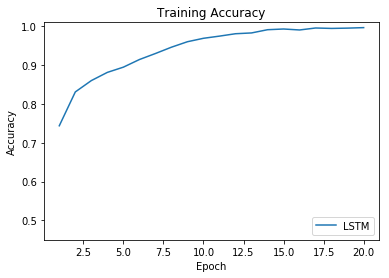

In [28]:
# Training Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['acc'])
plt.legend(['LSTM'], loc='lower right')
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([0.45,1.01])
plt.xlabel("Epoch")
plt.title("Training Accuracy")
plt.show()

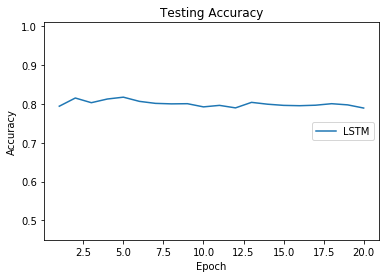

In [30]:
# Testing Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['val_acc'])
plt.legend(['LSTM'], loc='right')
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([0.45,1.01])
plt.xlabel("Epoch")
plt.title("Testing Accuracy")
plt.show()

In [32]:
zhang_lecun_vocab=list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}") 
vocab_hash = {b: a for a, b in enumerate(zhang_lecun_vocab)}

def to_one_hot(txt, length = max_len, vocab=vocab_hash):
    
    vocab_size = len(vocab.keys())
    one_hot_vec = np.zeros((vocab_size, length), dtype=np.float32)
    # run through txt and "switch on" relevant positions in one-hot vector
    for idx, char in enumerate(txt):
        try:
            vocab_idx = vocab_hash[char]
            one_hot_vec[vocab_idx, idx] = 1
        # raised if character is out of vocabulary
        except:
            #print(char)
            pass
    return one_hot_vec

In [33]:
to_one_hot("Something on Temporal Convolutional Networks")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
def one_hot_cnn(dense_out, max_len=300, frame='small'):

    if frame == 'large':
        cnn_size = 1024
        fully_connected = [2048,2048,dense_out]
    elif frame =='small':
        cnn_size = 256
        fully_connected = [1024,1024,dense_out]
    elif frame =='tiny':
        cnn_size = 128
        fully_connected = [512,512,dense_out]
        

    model = Sequential()

    model.add(Conv1D(cnn_size, 7, padding='same', input_shape=(67, max_len)))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 22 x cnn_size
    model.add(Conv1D(cnn_size, 7, padding='same'))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    model.add(Conv1D(cnn_size,3, padding='same'))

    # #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size, 3, padding='same'))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Flatten())

    #Fully Connected Layers

    #Input is 512 Output is 1024/2048
    model.add(Dense(fully_connected[0]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is 1024/2048
    model.add(Dense(fully_connected[1]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is dense_out size (number of classes)
    model.add(Dense(fully_connected[2]))
    model.add(Activation('softmax'))

    #Stochastic gradient parameters as set by paper
    sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [35]:
X_train_a_ = [to_one_hot(x) for x in X_train_]
X_test_a_ = [to_one_hot(x) for x in X_test_]

X_train_a = np.asarray(X_train_a_)
Y_train_a = Y_train_

X_test_a = np.asarray(X_test_a_)
Y_test_a = Y_test_

print(X_train_a.shape)

(9281, 67, 300)


In [36]:
model_cnn = one_hot_cnn(dense_out, frame='small')
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 67, 256)           537856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 256)           459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 256)            196864    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 256)            196864    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 256)            196864    
__________

In [37]:
model_hist_cnn = model_cnn.fit(X_train_a, Y_train_a, batch_size=64, epochs=20, verbose=1, 
          validation_data=(X_test_a,Y_test_a))

Train on 9281 samples, validate on 2321 samples
Epoch 1/20
9281/9281 [==============================] - 50s 5ms/step - loss: 0.7058 - acc: 0.5082 - val_loss: 0.7093 - val_acc: 0.4847
Epoch 2/20
9281/9281 [==============================] - 52s 6ms/step - loss: 0.7064 - acc: 0.5027 - val_loss: 0.6923 - val_acc: 0.5153
Epoch 3/20
9281/9281 [==============================] - 55s 6ms/step - loss: 0.7004 - acc: 0.5090 - val_loss: 0.6973 - val_acc: 0.4847
Epoch 4/20
9281/9281 [==============================] - 51s 5ms/step - loss: 0.6989 - acc: 0.5045 - val_loss: 0.6928 - val_acc: 0.5153
Epoch 5/20
9281/9281 [==============================] - 50s 5ms/step - loss: 0.6964 - acc: 0.5148 - val_loss: 0.6930 - val_acc: 0.5153
Epoch 6/20
9281/9281 [==============================] - 51s 5ms/step - loss: 0.6869 - acc: 0.5415 - val_loss: 0.7009 - val_acc: 0.5192
Epoch 7/20
9281/9281 [==============================] - 51s 6ms/step - loss: 0.6366 - acc: 0.6401 - val_loss: 1.3130 - val_acc: 0.5153
Epoch 8

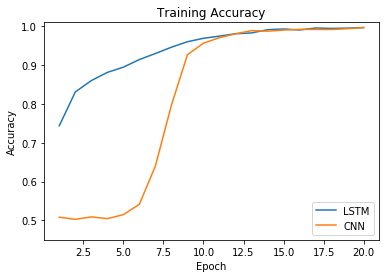

In [38]:
# Training Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['acc'])
plt.plot(x, model_hist_cnn.history['acc'])
plt.legend(['LSTM', 'CNN'], loc='lower right')
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([0.45,1.01])
plt.xlabel("Epoch")
plt.title("Training Accuracy")
plt.show()

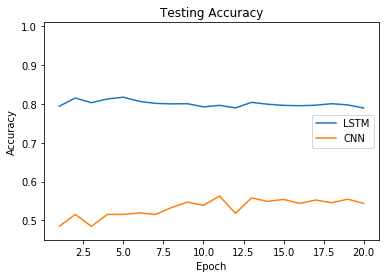

In [39]:
# Testing Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['val_acc'])
plt.plot(x, model_hist_cnn.history['val_acc'])
plt.legend(['LSTM', 'CNN'], loc='right')
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([0.45,1.01])
plt.xlabel("Epoch")
plt.title("Testing Accuracy")
plt.show()